In [628]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import stat
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose  
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
import tensorflow as tf

In [629]:
bmd = pd.read_csv('building_metadata.csv')

In [630]:
bmd

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [631]:
full_df = pd.read_csv('train.csv',index_col='timestamp',parse_dates=True, infer_datetime_format=True)

In [632]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [633]:
full_df = reduce_mem_usage(full_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)


In [634]:
full_df

,building_id,meter,meter_reading
timestamp,,,
2016-01-01 00:00:00,0,0,0.000000
2016-01-01 00:00:00,1,0,0.000000
2016-01-01 00:00:00,2,0,0.000000
2016-01-01 00:00:00,3,0,0.000000
2016-01-01 00:00:00,4,0,0.000000
...,...,...,...
2016-12-31 23:00:00,1444,0,8.750000
2016-12-31 23:00:00,1445,0,4.825000
2016-12-31 23:00:00,1446,0,0.000000


In [635]:
full_df = full_df[full_df['meter']==0]

In [636]:
full_df = full_df.drop('meter', axis = 1)

In [637]:
full_df.head()

,building_id,meter_reading
timestamp,,
2016-01-01,0,0.0
2016-01-01,1,0.0
2016-01-01,2,0.0
2016-01-01,3,0.0
2016-01-01,4,0.0


In [638]:
full_df_piv = pd.pivot_table(full_df, index=full_df.index, columns='building_id')

In [639]:
full_df_piv

meter_reading                                              \
building_id                  0          1       2           3            4      
timestamp                                                                       
2016-01-01 00:00:00      0.000000   0.000000  0.0000    0.000000     0.000000   
2016-01-01 01:00:00      0.000000   0.000000  0.0000    0.000000     0.000000   
2016-01-01 02:00:00      0.000000   0.000000  0.0000    0.000000     0.000000   
2016-01-01 03:00:00      0.000000   0.000000  0.0000    0.000000     0.000000   
2016-01-01 04:00:00      0.000000   0.000000  0.0000    0.000000     0.000000   
...                           ...        ...     ...         ...          ...   
2016-12-31 19:00:00    232.070999  68.255997  4.9144  107.162003  1150.800049   
2016-12-31 20:00:00    189.069000  52.420601  5.3240  107.162003  1197.890015   
2016-12-31 21:00:00    169.957993  53.512699  5.7335  106.820999  1147.380005   
2016-12-31 22:00:00    169.957993  54.331799  4.9144  104.089996  1130.319946   
2016-12-31 23:00:00    175.417999  51.055500  4.9144  102.724998  1162.400024   

                                                                               \
building_id               5           6           7           8          9      
timestamp                                                                       
2016-01-01 00:00:00   0.000000    0.000000    0.000000    0.000000   0.000000   
2016-01-01 01:00:00   0.000000    0.000000    0.000000    0.000000   0.000000   
2016-01-01 02:00:00   0.000000    0.000000    0.000000    0.000000   0.000000   
2016-01-01 03:00:00   0.000000    0.000000    0.000000    0.000000   0.000000   
2016-01-01 04:00:00   0.000000    0.000000    0.000000    0.000000   0.000000   
...                        ...         ...         ...         ...        ...   
2016-12-31 19:00:00  10.238400  264.970001  550.825989  555.604004  61.430401   
2016-12-31 20:00:00  18.770399  265.378998  593.145020  577.445984  61.430401   
2016-12-31 21:00:00   9.214600  263.740997  557.992981  540.245972  63.068600   
2016-12-31 22:00:00  17.405300  258.826996  551.849976  513.968018  61.840000   
2016-12-31 23:00:00   8.873300  259.645996  535.468018  505.436005  61.840000   

                     ...                                                 \
building_id          ...        1439        1440        1441       1442   
timestamp            ...                                                  
2016-01-01 00:00:00  ...  201.600006  160.949997  248.524994  54.625000   
2016-01-01 01:00:00  ...  204.649994  165.250000  259.375000  63.224998   
2016-01-01 02:00:00  ...  202.774994  161.675003  250.475006  53.674999   
2016-01-01 03:00:00  ...  199.800003  164.850006  259.625000  58.075001   
2016-01-01 04:00:00  ...  197.699997  158.750000  247.399994  58.500000   
...                  ...         ...         ...         ...        ...   
2016-12-31 19:00:00  ...  176.524994  165.824997  245.675003  61.500000   
2016-12-31 20:00:00  ...  171.225006  163.875000  250.125000  55.474998   
2016-12-31 21:00:00  ...  169.725006  162.399994  247.875000  61.924999   
2016-12-31 22:00:00  ...  164.750000  154.699997  247.574997  58.349998   
2016-12-31 23:00:00  ...  167.399994  154.750000  242.925003  59.400002   

                                                                      
building_id               1443   1444   1445 1446        1447   1448  
timestamp                                                             
2016-01-01 00:00:00  57.724998  5.425  4.800  0.0  160.199997  2.325  
2016-01-01 01:00:00  63.349998  5.550  4.825  0.0  156.649994  2.225  
2016-01-01 02:00:00  62.875000  5.900  5.125  0.0  157.574997  2.275  
2016-01-01 03:00:00  64.250000  5.525  5.225  0.0  154.925003  2.575  
2016-01-01 04:00:00  64.675003  5.725  5.250  0.0  156.074997  3.075  
...                        ...    ...    ...  ...         ...    ...  
2016-12-31 19:00:00  83.724998  8.525  5.750  0.0  167.80000

In [640]:
full_df_piv.columns = full_df_piv.columns.droplevel()

In [641]:
full_df_piv.head()

building_id,0,1,2,3,4,5,6,7,8,9,...,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,201.600006,160.949997,248.524994,54.625000,57.724998,5.425,4.800,0.0,160.199997,2.325
2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,204.649994,165.250000,259.375000,63.224998,63.349998,5.550,4.825,0.0,156.649994,2.225
2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,202.774994,161.675003,250.475006,53.674999,62.875000,5.900,5.125,0.0,157.574997,2.275
2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,199.800003,164.850006,259.625000,58.075001,64.250000,5.525,5.225,0.0,154.925003,2.575
2016-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,197.699997,158.750000,247.399994,58.500000,64.675003,5.725,5.250,0.0,156.074997,3.075


In [642]:
mean_usage = full_df_piv.mean(axis = 0) 

In [643]:
mean_usage

building_id
0       146.454697
1        74.865501
2        14.551390
3       235.549988
4       976.557007
           ...    
1444      7.482129
1445      4.732813
1446      3.592165
1447    187.117889
1448      3.338596
Length: 1413, dtype: float32

In [644]:
type(mean_usage)

pandas.core.series.Series

In [645]:
mean_usage_df = mean_usage.to_frame(name='mean_usage')

In [646]:
mean_usage_df

,mean_usage
building_id,
0,146.454697
1,74.865501
2,14.551390
3,235.549988
4,976.557007
...,...
1444,7.482129
1445,4.732813
1446,3.592165


In [647]:
bmd

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [648]:
# Merge

merged = bmd.merge(mean_usage_df, left_index=True, right_index=True, how='inner')

In [649]:
merged

,site_id,building_id,primary_use,square_feet,year_built,floor_count,mean_usage
0,0,0,Education,7432,2008.0,NaN,146.454697
1,0,1,Education,2720,2004.0,NaN,74.865501
2,0,2,Education,5376,1991.0,NaN,14.551390
3,0,3,Education,23685,2002.0,NaN,235.549988
4,0,4,Education,116607,1975.0,NaN,976.557007
...,...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN,7.482129
1445,15,1445,Education,4298,NaN,NaN,4.732813
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN,3.592165
1447,15,1447,Lodging/residential,29775,2001.0,NaN,187.117889


In [650]:
merged.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448],
           dtype='int64', length=1413)

In [651]:
merged.isnull().any()

site_id        False
building_id    False
primary_use    False
square_feet    False
year_built      True
floor_count     True
mean_usage     False
dtype: bool

In [652]:
# 750 NaNs in series... that's quite alot -> will just remove
merged['year_built'].isna().sum()

750

In [653]:
# 1061 NaNs in series... that's quite alot -> will just remove
merged['floor_count'].isna().sum()

1061

In [654]:
merged.drop(['year_built', 'floor_count'], axis =1)

,site_id,building_id,primary_use,square_feet,mean_usage
0,0,0,Education,7432,146.454697
1,0,1,Education,2720,74.865501
2,0,2,Education,5376,14.551390
3,0,3,Education,23685,235.549988
4,0,4,Education,116607,976.557007
...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,7.482129
1445,15,1445,Education,4298,4.732813
1446,15,1446,Entertainment/public assembly,11265,3.592165
1447,15,1447,Lodging/residential,29775,187.117889


In [655]:
cleaned_df = merged.drop(['year_built', 'floor_count'], axis =1)

In [656]:
cleaned_df 

,site_id,building_id,primary_use,square_feet,mean_usage
0,0,0,Education,7432,146.454697
1,0,1,Education,2720,74.865501
2,0,2,Education,5376,14.551390
3,0,3,Education,23685,235.549988
4,0,4,Education,116607,976.557007
...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,7.482129
1445,15,1445,Education,4298,4.732813
1446,15,1446,Entertainment/public assembly,11265,3.592165
1447,15,1447,Lodging/residential,29775,187.117889


In [657]:
cleaned_df['mean_usage'].max()

4650.169921875

In [658]:
cleaned_df.describe()

,site_id,building_id,square_feet,mean_usage
count,1413.000000,1413.000000,1413.000000,1413.000000
mean,6.842180,714.958953,92204.792640,169.801117
std,4.985376,418.115709,111412.340117,334.306732
min,0.000000,0.000000,283.000000,0.000400
25%,3.000000,353.000000,22949.000000,26.393579
50%,5.000000,706.000000,57673.000000,71.222099
75%,13.000000,1073.000000,115288.000000,171.028519
max,15.000000,1448.000000,875000.000000,4650.169922


In [659]:
# Later i can feature engineer something for these removed columns

In [660]:
cleaned_df['primary_use'].nunique()

16

In [661]:
#cleaned_df = cleaned_df.drop('site_id', axis = 1)

In [662]:
# Want to predict energy usage -> y

In [663]:
cleaned_df.iloc[:,-1]

0       146.454697
1        74.865501
2        14.551390
3       235.549988
4       976.557007
           ...    
1444      7.482129
1445      4.732813
1446      3.592165
1447    187.117889
1448      3.338596
Name: mean_usage, Length: 1413, dtype: float32

In [664]:
cleaned_df.iloc[:,0:-1]

,site_id,building_id,primary_use,square_feet
0,0,0,Education,7432
1,0,1,Education,2720
2,0,2,Education,5376
3,0,3,Education,23685
4,0,4,Education,116607
...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619
1445,15,1445,Education,4298
1446,15,1446,Entertainment/public assembly,11265
1447,15,1447,Lodging/residential,29775


In [665]:
# Can one hot encode this

In [666]:
X = cleaned_df.iloc[:,0:-1].values
y = cleaned_df.iloc[:,-1].values

In [667]:
X

array([[0, 0, 'Education', 7432],
       [0, 1, 'Education', 2720],
       [0, 2, 'Education', 5376],
       ...,
       [15, 1446, 'Entertainment/public assembly', 11265],
       [15, 1447, 'Lodging/residential', 29775],
       [15, 1448, 'Office', 92271]], dtype=object)

In [668]:
y

array([146.4547   ,  74.8655   ,  14.55139  , ...,   3.5921652,
       187.11789  ,   3.3385963], dtype=float32)

In [669]:
# One Hot Encoding the "Primary Use" column
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [2])], remainder='passthrough')


In [670]:
ct

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('encoder',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=True),
                                 [2])],
                  verbose=False)

In [671]:
X = ct.fit_transform(X).toarray()


In [672]:
X.shape

(1413, 19)

In [673]:
from sklearn.model_selection import train_test_split
train_test_split

<function sklearn.model_selection._split.train_test_split(*arrays, **options)>

In [674]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [675]:
#Now scale!
from sklearn.preprocessing import MinMaxScaler

In [676]:
scaler = MinMaxScaler()

In [677]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [678]:
#Get ANN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [697]:
X_train.shape

(1130, 19)

In [698]:
# Need 19 neurons per layer

In [705]:
model = Sequential()
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())

In [706]:
from tensorflow.keras.callbacks import EarlyStopping #Callback

In [707]:
early_stop = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 25)
#Could maximise accuracy...

In [708]:
model.fit(x = X_train, y = y_train, epochs = 600, validation_data=(X_test,y_test),
         callbacks = [early_stop])

Epoch 1/600
36/36 [==============================] - 0s 5ms/step - loss: 16.1822 - val_loss: 14.4035
Epoch 2/600
36/36 [==============================] - 0s 3ms/step - loss: 10.2948 - val_loss: 8.1099
Epoch 3/600
36/36 [==============================] - 0s 3ms/step - loss: 5.3602 - val_loss: 4.3123
Epoch 4/600
36/36 [==============================] - 0s 3ms/step - loss: 3.0223 - val_loss: 2.7788
Epoch 5/600
36/36 [==============================] - 0s 3ms/step - loss: 2.2298 - val_loss: 2.2518
Epoch 6/600
36/36 [==============================] - 0s 3ms/step - loss: 1.9935 - val_loss: 2.0856
Epoch 7/600
36/36 [==============================] - 0s 3ms/step - loss: 1.9196 - val_loss: 2.0158
Epoch 8/600
36/36 [==============================] - 0s 3ms/step - loss: 1.8840 - val_loss: 1.9748
Epoch 9/600
36/36 [==============================] - 0s 3ms/step - loss: 1.8600 - val_loss: 1.9486
Epoch 10/600
36/36 [==============================] - 0s 3ms/step - loss: 1.8380 - val_loss: 1.9254
Epoch 

In [709]:
model_loss = pd.DataFrame(model.history.history)

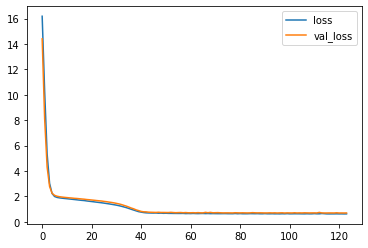

In [710]:
model_loss.plot()

In [711]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

In [712]:
#Make predictions
predicitions = model.predict(X_test)

In [713]:
#square of house price which is huge
mean_squared_error(y_test,predicitions)

87762.19

In [716]:
#RMS error
np.sqrt(mean_squared_error(y_test,predicitions))

296.24683

In [717]:
#mean absolute error
mean_absolute_error(y_test,predicitions)

106.259155

In [718]:
# Accurate to within 106 kWh

In [719]:
#best score is 1.0 -> how much variance is being explained by the model??
explained_variance_score(y_test,predicitions)

0.3554421663284302

In [ ]:
#Plot predicitions vs perfect fit
plt.figure(figsize=(12,6))
plt.scatter(y_test,predicitions)
plt.plot(y_test,y_test, 'r')


In [ ]:
#Massive buildings are messing up the ANN

In [ ]:
new_building = cleaned_df.iloc[:,0:-1]

In [ ]:
new_building

In [ ]:
X